The paper to be replicated: https://arxiv.org/abs/1710.06071

In [33]:
import pandas as pd
import numpy as np
import tensorflow as tf

from importlib.machinery import SourceFileLoader
 
# imports the module from the given path
helpers_path = "G:/My Drive/Computer Science/ML_DataSci/Data Science Custom Notebooks/Tensorflow/helper_functions.py"
helpers = SourceFileLoader("gfg",helpers_path).load_module()


# Download Data

In [34]:
# !git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!dir pubmed-rct

 Volume in drive G is Google Drive
 Volume Serial Number is 1983-1116

 Directory of g:\My Drive\Computer Science\ML_DataSci\ML_Practice_Projects\SkimLit\pubmed-rct

03/16/2023  10:06 PM    <DIR>          .
03/15/2023  02:54 PM    <DIR>          ..
03/09/2023  02:41 AM    <DIR>          PubMed_20k_RCT
03/09/2023  02:41 AM    <DIR>          PubMed_20k_RCT_numbers_replaced_with_at_sign
03/09/2023  02:41 AM             2,403 README.md
               1 File(s)          2,403 bytes
               4 Dir(s)  44,590,161,920 bytes free


# Preprocessing of 10% Dataset

In [35]:
headings = ["BACKGROUND", "OBJECTIVE", "METHODS", "RESULTS", "CONCLUSIONS"]
def get_lines(filename):
  """
  Reads filename (a text filename) and returns the lines of text as a list.

  Args:
    filename: a string containing the target filepath.

  Returns:
    A list of strings with one string per line from the target filename.
  """
  with open(filename, "r") as f:
    return f.readlines()

def preprocess_text_with_line_numbers(filename):
  """
  Returns a list of dictionaries of abstract line data.

  Takes in filename, reads it contents and sorts through each line,
  extracting things like the target label, the text of the sentnece,
  how many sentences are in the current abstract and what sentence
  number the target line is.
  """
  input_lines = get_lines(filename) # get all lines from filename
  abstract_lines = "" # create an empty abstract
  abstract_samples = [] # create an empty list of abstracts

  # Loop through each line in the target file
  for line in input_lines:
    if line.startswith("###"): # check to see if the is an ID line
      abstract_id = line
      abstract_lines = "" # reset the abstract string if the line is an ID line

    elif line.isspace(): # check to see if line is a new line
      abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines

      # Iterate through each line in a single abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # create an empty dictionary for each line
        target_text_split = abstract_line.split("\t") # split target label from text 
        line_data["target"] = target_text_split[0] # get target label
        line_data["text"] = target_text_split[1].lower() # get target text and lower it
        line_data["line_number"] = abstract_line_number # what number line does the line appear in the abstract?
        line_data["total_lines"] = len(abstract_line_split) - 1 # how many total lines are there in the target abstract? (start from 0)
        abstract_samples.append(line_data) # add line data to abstract samples list

    else: # if the above conditions aren't fulfilled, the line contains a labelled sentence
      abstract_lines += line
  
  return abstract_samples

In [36]:
train_path_20k = "./pubmed-rct/PubMed_20k_RCT/train.txt"
val_path_20k = "./pubmed-rct/PubMed_20k_RCT/dev.txt"

test_path_20k= "./pubmed-rct/PubMed_20k_RCT/test.txt"

train_data_20k = preprocess_text_with_line_numbers(train_path_20k)
val_data_20k = preprocess_text_with_line_numbers(val_path_20k)
test_data_20k = preprocess_text_with_line_numbers(test_path_20k)


In [37]:
train_data_20k[:3]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of 6 weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at 12 weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of 125 patients with primary knee oa were randomized 1:1 ; 63 received 7.5 mg/day of prednisolone and 62 received placebo for 6 weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11}]

In [38]:
train_df_20k = pd.DataFrame(train_data_20k)
val_df_20k = pd.DataFrame(val_data_20k)
test_df_20k = pd.DataFrame(test_data_20k)
train_df_20k.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of 6 weeks of dail...,0,11
1,METHODS,a total of 125 patients with primary knee oa w...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


In [152]:
train_sentences = train_df_20k["text"].to_numpy()
val_sentences = val_df_20k["text"].to_numpy()
test_sentences = test_df_20k["text"].to_numpy()

train_sentences[:3]

array(['to investigate the efficacy of 6 weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at 12 weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
       'a total of 125 patients with primary knee oa were randomized 1:1 ; 63 received 7.5 mg/day of prednisolone and 62 received placebo for 6 weeks .',
       'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .'],
      dtype=object)

In [40]:
print(train_df_20k["target"].value_counts())

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64


In [41]:
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df_20k["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df_20k["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df_20k["target"].to_numpy().reshape(-1, 1))

train_labels_one_hot[:3]

c:\Users\jxa32\anaconda3\envs\datascience\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.]])

In [42]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df_20k["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df_20k["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df_20k["target"].to_numpy())
val_labels_encoded

array([0, 0, 3, ..., 4, 1, 1])

In [43]:
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Model 0: Baseline Naive Bayes with TF-IDF encoder

In [44]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB

model_0 = Pipeline([
    ('tf-idf', TfidfVectorizer()),
    ('clf', MultinomialNB())
])

model_0.fit(X=train_sentences, y=train_labels_encoded)

model_0.score(X=val_sentences, y=val_labels_encoded)

model_0_preds = model_0.predict(val_sentences)
model_0_preds

KeyboardInterrupt: 

In [ ]:
model_0_results = helpers.calculate_results(y_true=val_labels_encoded,
                                            y_pred=model_0_preds)
model_0_results

{'accuracy': 73.17291142592347,
 'precision': 73.15166696974572,
 'recall': 73.17291142592347,
 'f1': 70.58060715307974}

## Preprocessing for rest of models

In [59]:
from tensorflow.keras import layers
sentence_length = [len(sentence.split()) for sentence in train_sentences]
avg_sent_length = np.mean(sentence_length)
avg_sent_length


26.338435903132638

(array([4.2075e+04, 8.3770e+04, 3.6878e+04, 1.0945e+04, 3.9310e+03,
        1.4450e+03, 5.6000e+02, 2.2600e+02, 1.0100e+02, 4.5000e+01,
        2.0000e+01, 1.2000e+01, 9.0000e+00, 1.0000e+01, 6.0000e+00,
        2.0000e+00, 3.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([  1.  ,  15.75,  30.5 ,  45.25,  60.  ,  74.75,  89.5 , 104.25,
        119.  , 133.75, 148.5 , 163.25, 178.  , 192.75, 207.5 , 222.25,
        237.  , 251.75, 266.5 , 281.25, 296.  ]),
 <BarContainer object of 20 artists>)

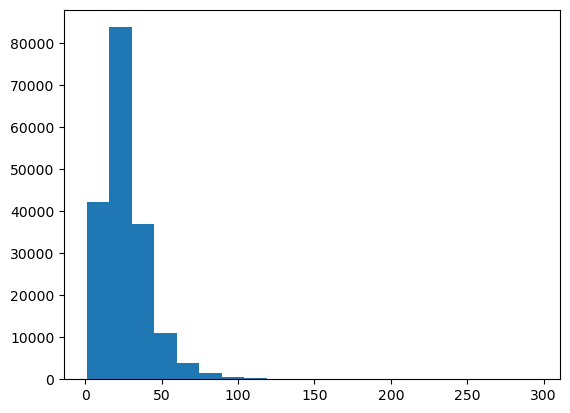

In [60]:
import matplotlib.pyplot as plt
plt.hist(sentence_length, bins=20)


In [61]:
output_seq_len = int(np.percentile(sentence_length, 95))
output_seq_len

55

In [62]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
import random
max_tokens = 68000

text_vectorizer = TextVectorization(max_tokens=max_tokens,
                                    output_sequence_length=output_seq_len)

text_vectorizer.adapt(train_sentences)
target_sentence = random.choice(train_sentences)
print(f"text: {target_sentence}")
print(f"sentence length: {len(target_sentence.split())}")
print(f"vectorized text: {text_vectorizer([target_sentence])}")

rtc_20k_text_vocab = text_vectorizer.get_vocabulary()
text_vectorizer.get_config()

text: although studies have addressed the impact of physical exercise in cerebrovascular prevention and rehabilitation , the underlying mechanisms leading to improvement are poorly understood .
sentence length: 25
vectorized text: [[ 334  211  104 4314    2  326    4  198  188    5 3434  432    3  572
     2 1880 1256 1670    6  204   59 3275 3868    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]


{'name': 'text_vectorization',
 'trainable': True,
 'batch_input_shape': (None,),
 'dtype': 'string',
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None}

In [63]:
token_embed = layers.Embedding(input_dim=len(rtc_20k_text_vocab),
                               output_dim=128,
                               mask_zero=True)

print(text_vectorizer(target_sentence))
                               

tf.Tensor(
[ 334  211  104 4314    2  326    4  198  188    5 3434  432    3  572
    2 1880 1256 1670    6  204   59 3275 3868    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0], shape=(55,), dtype=int64)


In [64]:
# speeding up performance
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [65]:
train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

## Model 1: Conv1D with token embedding

In [66]:
tf.random.set_seed(42)

inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = token_embed(x)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(5, activation="softmax")(x)
model_1 = tf.keras.Model(inputs, outputs, name="model_1")
model_1.compile(loss="categorical_crossentropy",
                optimizer="Adam",
                metrics=["accuracy"])
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 55, 128)           8704000   
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense_1 (Dense)             (None, 5)                 325 

In [ ]:
model_1_history = model_1.fit(train_dataset,
                              steps_per_epoch=int(0.1*len(train_dataset)),
                              epochs=3,
                              validation_data=valid_dataset,
                              validation_steps=int(0.1*len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 25s 44ms/step - loss: 0.9102 - accuracy: 0.6386 - val_loss: 0.6754 - val_accuracy: 0.7417
Epoch 2/3
562/562 [==============================] - 24s 43ms/step - loss: 0.6460 - accuracy: 0.7615 - val_loss: 0.6165 - val_accuracy: 0.7756
Epoch 3/3
562/562 [==============================] - 24s 42ms/step - loss: 0.6072 - accuracy: 0.7782 - val_loss: 0.5873 - val_accuracy: 0.7872


<AxesSubplot: >

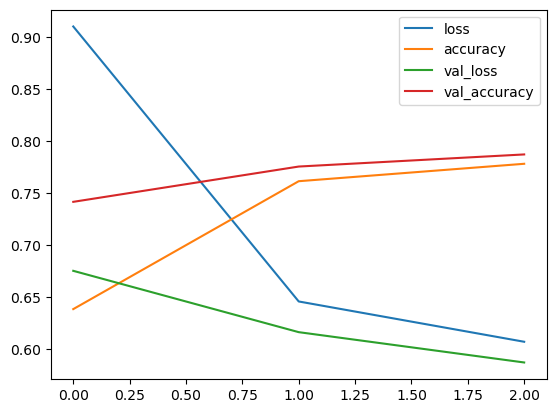

In [ ]:
pd.DataFrame(model_1_history.history).plot()

In [ ]:
model_1.evaluate(valid_dataset)
model_1_pred_probs = model_1.predict(test_dataset)
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)

942/942 [==============================] - 2s 2ms/step


In [ ]:
model_1_results = helpers.calculate_results(y_true=test_labels_encoded,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 78.47685415629667,
 'precision': 77.99150450580588,
 'recall': 78.47685415629667,
 'f1': 78.13810706332448}

## Model 2: Tensorflow Hub pretrained Feature Extractor

In [67]:
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                         trainable=False,
                                         name="universal_sentence_encoder")

In [68]:
random_train_sentence = random.choice(train_sentences)
print(f"Random sentence:\n {random_train_sentence}")
use_embedded_sentence = tf_hub_embedding_layer([random_train_sentence])
print(f"Setence after embedding:\n{use_embedded_sentence[0][:30]}\n")
print(f"Length of sentence embedding: {len(use_embedded_sentence[0])}")

Random sentence:
 all patients applied only ointment vehicle on contra lateral target lesion as intra-patient side to side control .
Setence after embedding:
[ 4.8789278e-02  4.1075021e-02 -1.9063370e-02  9.3151350e-03
  3.6206486e-05  2.3968823e-02 -3.1598069e-02  5.0068479e-02
  2.6023231e-02  7.1945548e-02  7.8225918e-02  3.7950695e-02
  1.9070128e-02  5.7881497e-02  4.3163482e-02 -6.7077866e-03
 -7.3165067e-02 -2.8012086e-02 -6.0283311e-02  8.4325615e-03
 -4.2157579e-02  1.4485404e-02 -3.2502234e-02 -7.0984386e-02
  7.2917461e-02 -4.2702522e-02  3.7547715e-02  3.3321466e-02
  1.7350793e-02  7.0776716e-02]

Length of sentence embedding: 512


In [ ]:
# dont need to use tokenizer with the universal sentence encoder emebedding layer
inputs = layers.Input(shape=[], dtype=tf.string)
pretrained_embedding = tf_hub_embedding_layer(inputs)
x = layers.Dense(128, activation="relu")(pretrained_embedding)
outputs = layers.Dense(5, activation="softmax")(x)

model_2 = tf.keras.Model(inputs, outputs, name="model_2_USE_feature_extractor")

model_2.compile(loss="categorical_crossentropy",
                optimizer="Adam",
                metrics=["accuracy"])

model_2.summary()

Model: "model_2_USE_feature_extractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder   (None, 512)              256797824 
 (KerasLayer)                                                    
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [ ]:
model_2.fit(train_dataset,
            epochs=3,
            steps_per_epoch=int(0.1*len(train_dataset)),
            validation_data=valid_dataset,
            validation_steps=int(0.1*len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 6s 6ms/step - loss: 0.8900 - accuracy: 0.6623 - val_loss: 0.7758 - val_accuracy: 0.6941
Epoch 2/3
562/562 [==============================] - 3s 6ms/step - loss: 0.7444 - accuracy: 0.7101 - val_loss: 0.7334 - val_accuracy: 0.7131
Epoch 3/3
562/562 [==============================] - 3s 5ms/step - loss: 0.7285 - accuracy: 0.7181 - val_loss: 0.7227 - val_accuracy: 0.7141


In [ ]:
model_2.evaluate(train_dataset)

5627/5627 [==============================] - 25s 4ms/step - loss: 0.7220 - accuracy: 0.7220


[0.7220097184181213, 0.7219506502151489]

In [ ]:
model_2_pred_probs = model_2.predict(test_dataset)
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_results = helpers.calculate_results(test_labels_encoded, model_2_preds)

942/942 [==============================] - 4s 4ms/step


In [ ]:
model_2_results

{'accuracy': 71.9827443172391,
 'precision': 72.26958167069577,
 'recall': 71.9827443172391,
 'f1': 71.7370859697154}

## Model 3: Conv1D with character embeddings

### Character level tokenizer

In [69]:
# Character level tokenizer
def split_chars(text):
    return " ".join(list(text))



In [70]:
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len


152.006276383026

(array([1.45323e+05, 3.31950e+04, 1.38800e+03, 1.07000e+02, 2.20000e+01,
        3.00000e+00, 2.00000e+00]),
 array([   2.        ,  209.42857143,  416.85714286,  624.28571429,
         831.71428571, 1039.14285714, 1246.57142857, 1454.        ]),
 <BarContainer object of 7 artists>)

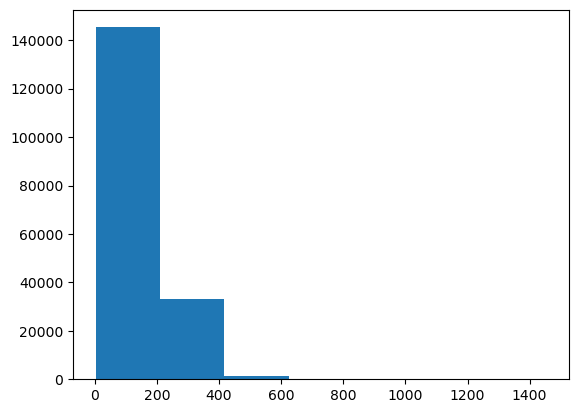

In [71]:
import matplotlib.pyplot as plt
plt.hist(char_lens, bins=7)

In [72]:
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

296

In [73]:
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [74]:
NUM_CHAR_TOKENS = len(alphabet) + 2
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                    output_sequence_length=output_seq_char_len,
                                    name="char_vectorizer")

char_vectorizer.adapt(train_chars)

In [75]:
char_vocab = char_vectorizer.get_vocabulary()
char_vocab
random_train_chars = random.choice(train_chars)
vectorized_chars = char_vectorizer([random_train_chars])

In [76]:
vectorized_chars

<tf.Tensor: shape=(1, 296), dtype=int64, numpy=
array([[ 4,  6, 25, 23, 23, 23,  5,  6,  2,  9,  3,  4, 15,  5,  3,  2,
        10, 34, 29, 32, 26, 11,  7,  6, 17,  4, 10,  2,  6, 11,  2,  4,
         6,  3,  2,  8, 21,  5, 12, 31, 32, 34, 32,  7, 17,  5, 10, 16,
        12,  3,  5, 15,  2,  8,  4, 11,  5,  6,  9, 20,  2,  8,  2, 14,
         8,  2,  9, 11,  8,  4, 14,  3,  4,  7,  6,  7, 14,  4,  7,  4,
        10, 16,  9,  2,  8,  9, 11,  7, 15, 14,  5,  8,  2, 10, 20,  4,
         3, 13, 24, 24, 33, 32, 26, 11,  7,  6, 17,  4, 10,  2,  6, 11,
         2,  4,  6,  3,  2,  8, 21,  5, 12, 24, 24, 25, 24, 25, 29,  4,
         6, 25, 23, 24, 23,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0, 

### Creating char level embedding

In [77]:
char_embed = layers.Embedding(input_dim=len(char_vocab),
                              output_dim=25,
                              mask_zero=True,
                              name="char_embed")

In [ ]:
inputs = layers.Input(shape=(1,), dtype="string")
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(char_embeddings)
x = layers.GlobalMaxPooling1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_3 = tf.keras.Model(inputs=inputs,
                         outputs=outputs,
                         name="model_3_conv1d_char_embeddings")

model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
model_3.summary()

Model: "model_3_conv1d_char_embeddings"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVector  (None, 296)              0         
 ization)                                                        
                                                                 
 char_embed (Embedding)      (None, 296, 25)           950       
                                                                 
 conv1d_1 (Conv1D)           (None, 296, 64)           8064      
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_3 (Dense)             (None, 

In [ ]:
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
model_3_history = model_3.fit(train_char_dataset,
                              steps_per_epoch=int(0.1*len(train_char_dataset)),
                              epochs=3,
                              validation_data=val_char_dataset,
                              validation_steps=int(0.1*len(val_char_dataset))
                              )

Epoch 1/3
562/562 [==============================] - 3s 5ms/step - loss: 1.1986 - accuracy: 0.5114 - val_loss: 1.0009 - val_accuracy: 0.6037
Epoch 2/3
562/562 [==============================] - 3s 5ms/step - loss: 0.9600 - accuracy: 0.6082 - val_loss: 0.9131 - val_accuracy: 0.6380
Epoch 3/3
562/562 [==============================] - 3s 5ms/step - loss: 0.8961 - accuracy: 0.6465 - val_loss: 0.8422 - val_accuracy: 0.6772


In [ ]:
model_3_pred_probs = model_3.predict(test_char_dataset)
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
model_3_preds

942/942 [==============================] - 2s 2ms/step


<tf.Tensor: shape=(30135,), dtype=int64, numpy=array([0, 2, 2, ..., 4, 4, 2], dtype=int64)>

In [ ]:
model_3_pred_probs

array([[0.33520576, 0.23211475, 0.13628905, 0.26658043, 0.02980995],
       [0.10149801, 0.20914659, 0.4535678 , 0.18027677, 0.05551082],
       [0.01151711, 0.0483122 , 0.71460754, 0.01722804, 0.20833519],
       ...,
       [0.0020187 , 0.03347431, 0.01338853, 0.00337113, 0.9477473 ],
       [0.01228909, 0.04571106, 0.24645881, 0.01092041, 0.68462056],
       [0.07337647, 0.11804725, 0.48814258, 0.04338714, 0.27704653]],
      dtype=float32)

In [ ]:
model_3_results = helpers.calculate_results(y_true=test_labels_encoded,
                                            y_pred=model_3_preds)

In [ ]:
model_3_results

{'accuracy': 66.39455782312925,
 'precision': 66.26607873455931,
 'recall': 66.39455782312925,
 'f1': 65.66334829301653}

## Model 4: Combined Pretrained token embeddings

In [ ]:
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_outputs)

char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(25))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output,
                                                                  char_model.output])

combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(128, activation="relu")(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)

output_layer = layers.Dense(num_classes, activation="softmax")(final_dropout)

model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs=output_layer,
                         name="model_4_token_and_char_embeddings")

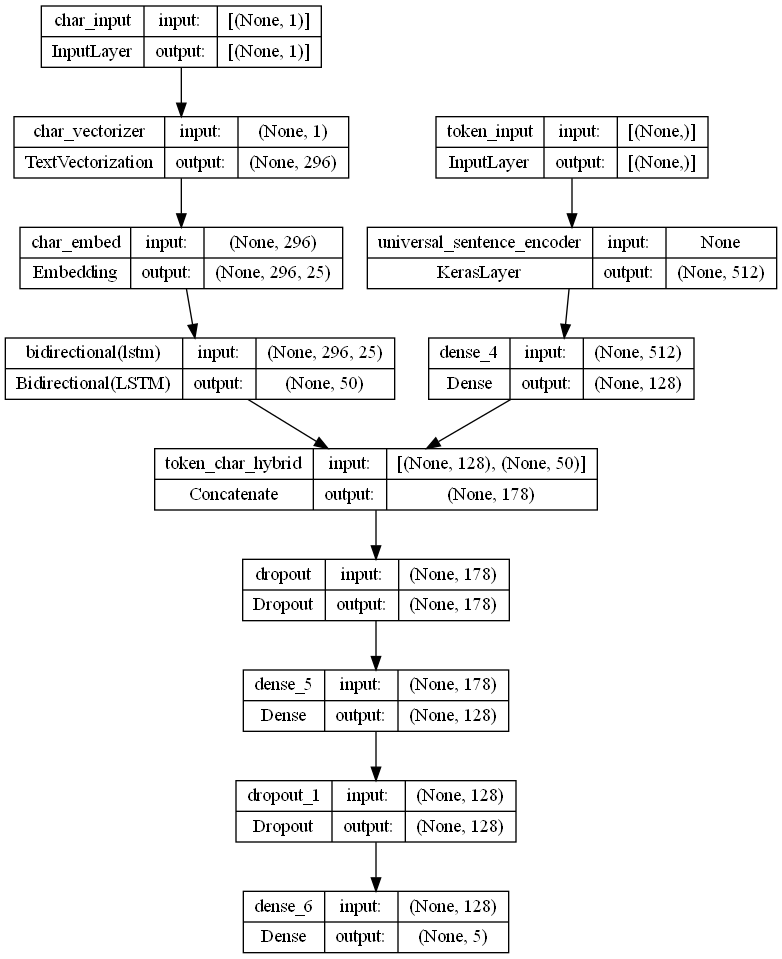

In [ ]:
from keras.utils import plot_model
plot_model(model_4, show_shapes=True)

In [ ]:

model_4.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(), # section 4.2 of the paper says they use SGD, you might want to try this
                metrics=["accuracy"])

In [ ]:
# Combine chars and tokens into a dataset
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars)) # make data
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # make labels
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels)) # combine data and labels

# Prefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
# Combine chars and tokens into a dataset
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars)) # make data
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot) # make labels
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels)) # combine data and labels

# Prefetch and batch train data
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
history_model_4 = model_4.fit(train_char_token_dataset,
                              steps_per_epoch=int(0.1*len(train_char_token_dataset)),
                              epochs=3,
                              validation_data=val_char_token_dataset,
                              validation_steps=int(0.1*len(val_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 91s 149ms/step - loss: 0.9533 - accuracy: 0.6210 - val_loss: 0.7543 - val_accuracy: 0.7141
Epoch 2/3
562/562 [==============================] - 82s 145ms/step - loss: 0.7774 - accuracy: 0.7033 - val_loss: 0.7511 - val_accuracy: 0.7061
Epoch 3/3
562/562 [==============================] - 81s 143ms/step - loss: 0.7496 - accuracy: 0.7148 - val_loss: 0.6732 - val_accuracy: 0.7397


In [ ]:
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
model_4_results = helpers.calculate_results(y_true=val_labels_encoded,
                                            y_pred=model_4_preds)
model_4_results

945/945 [==============================] - 31s 30ms/step


{'accuracy': 74.43068979213557,
 'precision': 74.58303924102901,
 'recall': 74.43068979213557,
 'f1': 74.22650554067835}

## Model 5

In [78]:
train_line_numbers_one_hot = tf.one_hot(train_df_20k["line_number"].to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df_20k["line_number"].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df_20k["line_number"].to_numpy(), depth=15)

In [79]:
train_line_numbers_one_hot.shape

TensorShape([180040, 15])

In [80]:
train_total_lines_one_hot = tf.one_hot(train_df_20k["total_lines"].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df_20k["total_lines"].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df_20k["total_lines"].to_numpy(), depth=20)


In [81]:
train_total_lines_one_hot.shape, train_total_lines_one_hot[:10]

(TensorShape([180040, 20]),
 <tf.Tensor: shape=(10, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0

In [82]:
from tensorflow.keras import layers
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                         trainable=False,
                                         name="universal_sentence_encoder")

# 1. Token inputs
token_inputs = layers.Input(shape=[], dtype="string", name="token_inputs")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_outputs)

# 2. Char inputs
char_inputs = layers.Input(shape=(1, ), dtype="string", name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Line numbers model
# inputs, shape = ?
line_number_inputs = layers.Input(shape=(15,), dtype=tf.float32, name="line_number_input")
# dense layer with 32 units & relu activation
x = layers.Dense(32, activation="relu")(line_number_inputs)
# combine inputs & dense layer into model
line_number_model = tf.keras.Model(inputs=line_number_inputs,
                                   outputs=x)

# 4. Total lines model
total_lines_inputs = layers.Input(shape=(20,), dtype=tf.float32, name="total_lines_input")
y = layers.Dense(32, activation="relu")(total_lines_inputs)
total_lines_model = tf.keras.Model(inputs=total_lines_inputs,
                                   outputs=y)

# 5. Combine token and char embeddings into a hybrid embedding
combined_embeddings = layers.Concatenate(name="char_token_hybrid_embedding")([token_model.output,
                                                                              char_model.output])

z = layers.Dense(256, activation="relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)

# 6. Combine positional embedding with combined token and char embeddings
tribrid_embeddings = layers.Concatenate(name="char_token_positional_embedding")([line_number_model.output,
                                                                                 total_lines_model.output,
                                                                                 z])

# 7. Create output layer
output_layer = layers.Dense(num_classes, activation="softmax", name="output_layer")(tribrid_embeddings)

# 8. Put together model with all kinds of inputs
model_5 = tf.keras.Model(inputs=[line_number_model.input,
                                 total_lines_model.input,
                                 token_model.input,
                                 char_model.input],
                         outputs=output_layer,
                         name="model_5_tribrid_embedding_model")

In [83]:
# Get a summary of our tribrid embedding model
model_5.summary()

Model: "model_5_tribrid_embedding_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_inputs (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 296)         0           ['char_inputs[0][0]']            
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['t

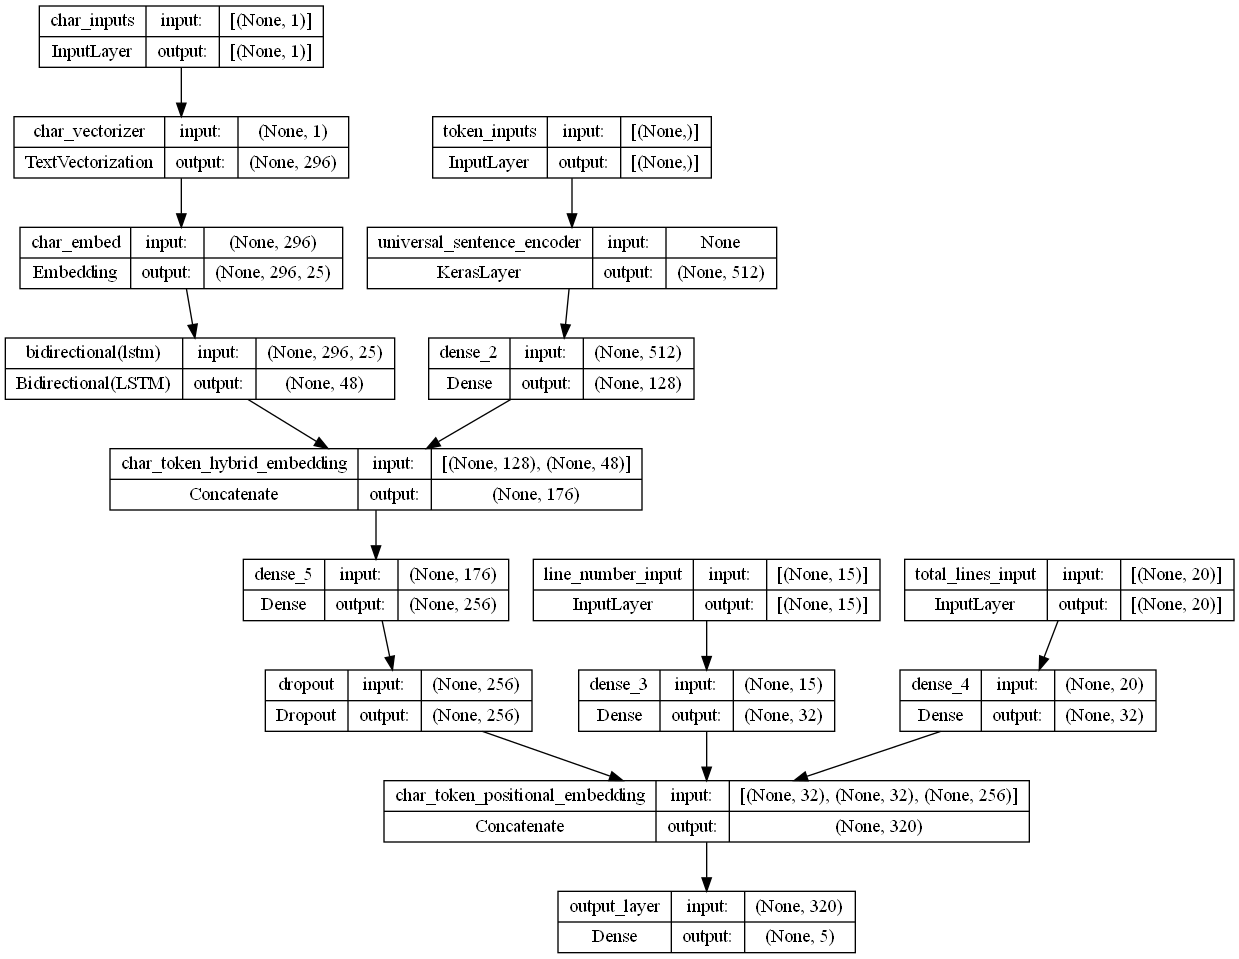

In [84]:
# Plot model_5 to explore it visually...
from tensorflow.keras.utils import plot_model
plot_model(model_5, show_shapes=True)

In [85]:
# Compile token, char, and positional embedding model
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), # helps to prevent overfitting
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [86]:
# Create training and valiadation datasets (with all four kinds of input data)
train_char_token_pos_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot,
                                                                train_total_lines_one_hot,
                                                                train_sentences,
                                                                train_chars))
train_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_pos_dataset = tf.data.Dataset.zip((train_char_token_pos_data, train_char_token_pos_labels))
train_char_token_pos_dataset = train_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Do the same as above but for the validation dataset
val_char_token_pos_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                              val_total_lines_one_hot,
                                                              val_sentences,
                                                              val_chars))
val_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_pos_dataset = tf.data.Dataset.zip((val_char_token_pos_data, val_char_token_pos_labels))
val_char_token_pos_dataset = val_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [87]:
# Fit our tribrid embedding model
history_model_5 = model_5.fit(train_char_token_pos_dataset,
                              steps_per_epoch=int(0.1 * len(train_char_token_pos_dataset)),
                              epochs=3,
                              validation_data=val_char_token_pos_dataset,
                              validation_steps=int(0.1 * len(val_char_token_pos_dataset)))

Epoch 1/3
562/562 [==============================] - 101s 162ms/step - loss: 1.0897 - accuracy: 0.7247 - val_loss: 0.9774 - val_accuracy: 0.8042
Epoch 2/3
562/562 [==============================] - 88s 157ms/step - loss: 0.9590 - accuracy: 0.8219 - val_loss: 0.9473 - val_accuracy: 0.8295
Epoch 3/3
562/562 [==============================] - 87s 155ms/step - loss: 0.9448 - accuracy: 0.8276 - val_loss: 0.9345 - val_accuracy: 0.8394


In [88]:
model_5_pred_probs = model_5.predict(val_char_token_pos_dataset, verbose=1)
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)
model_5_results = helpers.calculate_results(y_true=val_labels_encoded,
                                            y_pred=model_5_preds)
model_5_results

945/945 [==============================] - 33s 32ms/step


{'accuracy': 83.87726731100224,
 'precision': 83.77450746933293,
 'recall': 83.87726731100224,
 'f1': 83.7760700464344}

In [89]:
# Combine model results into a dataframe
all_model_results = pd.DataFrame({ "model_1_custom_token_embedding": model_1_results,
                                  "model_2_pretrained_token_embedding": model_2_results,
                                  "model_3_custom_char_embedding": model_3_results,
                                  "model_4_hybrid_char_token_embedding": model_4_results,
                                  "model_5_pos_char_token_embedding": model_5_results})
all_model_results = all_model_results.transpose()
all_model_results

NameError: name 'model_1_results' is not defined

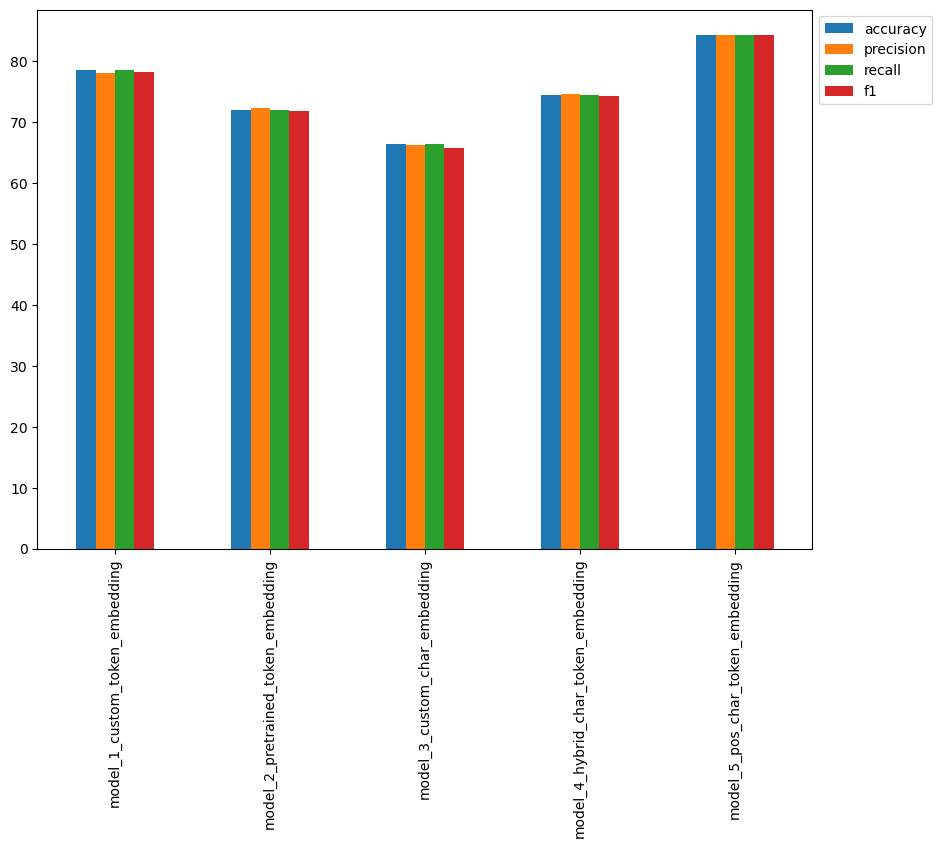

In [ ]:
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

In [90]:
model_5.save("skimlit_model")

INFO:tensorflow:Assets written to: skimlit_model\assets


INFO:tensorflow:Assets written to: skimlit_model\assets


In [91]:

# Do the same as above but for the validation dataset
val_char_token_pos_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                              val_total_lines_one_hot,
                                                              val_sentences,
                                                              val_chars))
val_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_pos_dataset = tf.data.Dataset.zip((val_char_token_pos_data, val_char_token_pos_labels))
val_char_token_pos_dataset = val_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [127]:

test_char_token_pos_data_for_predict = (test_line_numbers_one_hot,
                            test_total_lines_one_hot,
                            tf.constant(test_sentences),
                            tf.constant(test_chars))


# Do the same as above but for the validation dataset
test_char_token_pos_data = tf.data.Dataset.from_tensor_slices((test_line_numbers_one_hot,
                                                              test_total_lines_one_hot,
                                                              test_sentences,
                                                              test_chars))
test_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_char_token_pos_dataset = tf.data.Dataset.zip((test_char_token_pos_data, test_char_token_pos_labels))
test_char_token_pos_dataset = test_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [121]:
model_5_test_pred_probs = model_5.predict(x=test_char_token_pos_data_for_predict)

942/942 [==============================] - 32s 31ms/step


In [254]:
model_5_test_preds = tf.argmax(model_5_test_pred_probs, axis=1)

In [272]:
model_5_df = pd.DataFrame({"prediction":model_5_test_preds, "actual":test_labels_encoded})
model_5_df["prediction_prob"] = [model_5_test_pred_probs[x][model_5_df["prediction"].iloc[x]] for x in range(len(model_5_test_pred_probs))]
model_5_df["prediction_correct?"] = model_5_df["prediction"] == model_5_df["actual"]

In [278]:
top_10_most_wrong = model_5_df[model_5_df["prediction_correct?"] == False].sort_values("prediction_prob", ascending=False).head(10)
top_10_most_wrong

,prediction,actual,prediction_prob,prediction_correct?
8545,0,2,0.952056,False
13874,2,1,0.950028,False
2388,2,4,0.949584,False
16633,0,1,0.926665,False
16347,3,0,0.923245,False
3711,3,0,0.920847,False
13598,4,2,0.919765,False
4391,0,1,0.918534,False
9468,4,1,0.916450,False
25104,2,4,0.907640,False
